# MSDS 670 Final Project
Wiley Winters</br>
MSDS 670 Data Visualization</br>
2024-MAR-10</br>

---------------------------------------------------------------------
Import required packages and libraries

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from matplotlib import rcParams
from labellines import labelLine, labelLines
import numpy as np

# plotly
from plotly.offline import init_notebook_mode, iplot, plot
import plotly as py
import plotly.express as px
import plotly.graph_objs as go
init_notebook_mode(connected=True)

# Suppress Warnings
import warnings
warnings.filterwarnings('ignore')

# Set seaborn autoconfig to True
rcParams.update({'figure.autolayout': True})

Read datasets into Pandas DataFrames.  The main dataset is the one from the NCHS with the 10 leading causes of death in the United States.  The `states1999` and `states2011` contain population data for each state plus the total for the United States. In order to have the option to create a choropleth map of the United States, an abbreviation dataset was created.

In [2]:
causes_df = pd.read_csv('../data/NCHS_-_Leading_Causes_of_Death__United_States.csv')
states2000_df = pd.read_csv('../data/states2000-2010.csv')
states2010_df = pd.read_csv('../data/states2011-2019.csv')
abbrev_df = pd.read_csv('../data/stateAbb.csv')
print(causes_df.head())
print(states2000_df.head())
print(states2010_df.head())
print(abbrev_df.head())

   Year                                     113 Cause Name  \
0  2017  Accidents (unintentional injuries) (V01-X59,Y8...   
1  2017  Accidents (unintentional injuries) (V01-X59,Y8...   
2  2017  Accidents (unintentional injuries) (V01-X59,Y8...   
3  2017  Accidents (unintentional injuries) (V01-X59,Y8...   
4  2017  Accidents (unintentional injuries) (V01-X59,Y8...   

               Cause Name          State  Deaths  Age-adjusted Death Rate  
0  Unintentional injuries  United States  169936                     49.4  
1  Unintentional injuries        Alabama    2703                     53.8  
2  Unintentional injuries         Alaska     436                     63.7  
3  Unintentional injuries        Arizona    4184                     56.2  
4  Unintentional injuries       Arkansas    1625                     51.8  
   year          state  population
0  2000  United States   282162411
1  2000        Alabama     4452173
2  2000         Alaska      627963
3  2000        Arizona     5160

The column names in the `causes_df` DataFrame are not in a user friendly format.  I will rename them.


In [3]:
causes_df.rename({'Year':'year', '113 Cause Name': '113_cause_name',
                 'Cause Name':'cause_name', 'State': 'state', 'Deaths':'deaths',
                 'Age-adjusted Death Rate':'age_adjusted'}, axis=1, inplace=True)
causes_df.columns

Index(['year', '113_cause_name', 'cause_name', 'state', 'deaths',
       'age_adjusted'],
      dtype='object')

Combine all DataFrames into one.

In [4]:
# Concatenate states1999_df and states2011_df
states = pd.concat([states2000_df, states2010_df], ignore_index=True)
all_df = pd.merge(causes_df, states, on=['year', 'state'], how='inner')

Ensure all_df is sane enough to use

In [5]:
print(all_df.info())
print('\\nNaN Values:\\n', all_df.isna().sum())
print('\\nDuplicates: ', all_df.duplicated().sum())
print('\\nSize: ', all_df.size)
print('\\nDistribution:\\n', all_df.describe().T)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10296 entries, 0 to 10295
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   year            10296 non-null  int64  
 1   113_cause_name  10296 non-null  object 
 2   cause_name      10296 non-null  object 
 3   state           10296 non-null  object 
 4   deaths          10296 non-null  int64  
 5   age_adjusted    10296 non-null  float64
 6   population      10296 non-null  int64  
dtypes: float64(1), int64(3), object(3)
memory usage: 563.2+ KB
None
\nNaN Values:\n year              0
113_cause_name    0
cause_name        0
state             0
deaths            0
age_adjusted      0
population        0
dtype: int64
\nDuplicates:  0
\nSize:  72072
\nDistribution:\n                 count          mean           std       min         25%  \
year          10296.0  2.008500e+03  5.188379e+00    2000.0     2004.00   
deaths        10296.0  1.548406e+04  1.131075e+05

In [6]:
all_df.head()

,year,113_cause_name,cause_name,state,deaths,age_adjusted,population
0,2017,"Accidents (unintentional injuries) (V01-X59,Y8...",Unintentional injuries,United States,169936,49.4,325122128
1,2017,"Accidents (unintentional injuries) (V01-X59,Y8...",Unintentional injuries,Alabama,2703,53.8,4874486
2,2017,"Accidents (unintentional injuries) (V01-X59,Y8...",Unintentional injuries,Alaska,436,63.7,739700
3,2017,"Accidents (unintentional injuries) (V01-X59,Y8...",Unintentional injuries,Arizona,4184,56.2,7044008
4,2017,"Accidents (unintentional injuries) (V01-X59,Y8...",Unintentional injuries,Arkansas,1625,51.8,3001345


The `113_cause_name` column appears to be a more complicated version of `cause_name`.  I will drop the `113_cause_name` column.  It is not required for this analysis.

In [7]:
all_df.drop('113_cause_name', axis=1, inplace=True)

-------------------------------------------------------------------------------
When researching this project, I discovered that the *crude death rate* is often used by researchers as the death rate measure of choice.  The formula for it is $crude death rate = (number of deaths / total population) * 100,000$.  This will give the *crude death rate* per *100,000* people.  This will make it easier to compare states with large and small populations without having scaling issues.

In [8]:
# Create the crude_deaths column by calculating the crude death rate per 100,000
all_df['crude_deaths'] = round((all_df['deaths'] / all_df['population']) * 100000)

# Take a look at the results
all_df.head()

,year,cause_name,state,deaths,age_adjusted,population,crude_deaths
0,2017,Unintentional injuries,United States,169936,49.4,325122128,52.0
1,2017,Unintentional injuries,Alabama,2703,53.8,4874486,55.0
2,2017,Unintentional injuries,Alaska,436,63.7,739700,59.0
3,2017,Unintentional injuries,Arizona,4184,56.2,7044008,59.0
4,2017,Unintentional injuries,Arkansas,1625,51.8,3001345,54.0


-------------------------------------------------------------------------------
Explore the dataset to see what I have to work with

In [9]:
print('start--> ', all_df.year.min())
print('end-->   ', all_df.year.max())

start-->  2000
end-->    2017


In [10]:
print('age min: ', all_df.age_adjusted.min())
print('age max: ', all_df.age_adjusted.max())
print('crude_deaths min: ', all_df.crude_deaths.min())
print('crude_deaths max: ', all_df.crude_deaths.max())
print('deaths min: ', all_df.deaths.min())
print('deaths max: ', all_df.deaths.max())

age min:  2.6
age max:  1061.2
crude_deaths min:  3.0
crude_deaths max:  1281.0
deaths min:  21
deaths max:  2813503


In [11]:
all_df.value_counts('year')

year
2000    572
2001    572
2016    572
2015    572
2014    572
2013    572
2012    572
2011    572
2010    572
2009    572
2008    572
2007    572
2006    572
2005    572
2004    572
2003    572
2002    572
2017    572
Name: count, dtype: int64

In [12]:
all_df['cause_name'].value_counts()

cause_name
Unintentional injuries     936
All causes                 936
Alzheimer's disease        936
Stroke                     936
CLRD                       936
Diabetes                   936
Heart disease              936
Influenza and pneumonia    936
Suicide                    936
Cancer                     936
Kidney disease             936
Name: count, dtype: int64

The `Unintentional injuries` cause name is just another name for accidental death.  I will change the value to be `Accidents`.  It is easier to read.

In [13]:
all_df.cause_name = all_df.cause_name.apply(lambda x: 'Accidents'
                                            if x == 'Unintentional injuries'
                                            else x)

Another cause name that many people may not be familiar with is *CLRD*. It stands for *Chronic Lower Respiratory Disease*.  It is a group of disorders affecting the lungs and airways and is one of the leading causes of death in the United States.  I will rename this cause to `Respiratory disease`.  It is easier to understand.

In [14]:
all_df.cause_name = all_df.cause_name.apply(lambda x: 'Respiratory disease'
                                            if x == 'CLRD' else x)

Look as some groupings

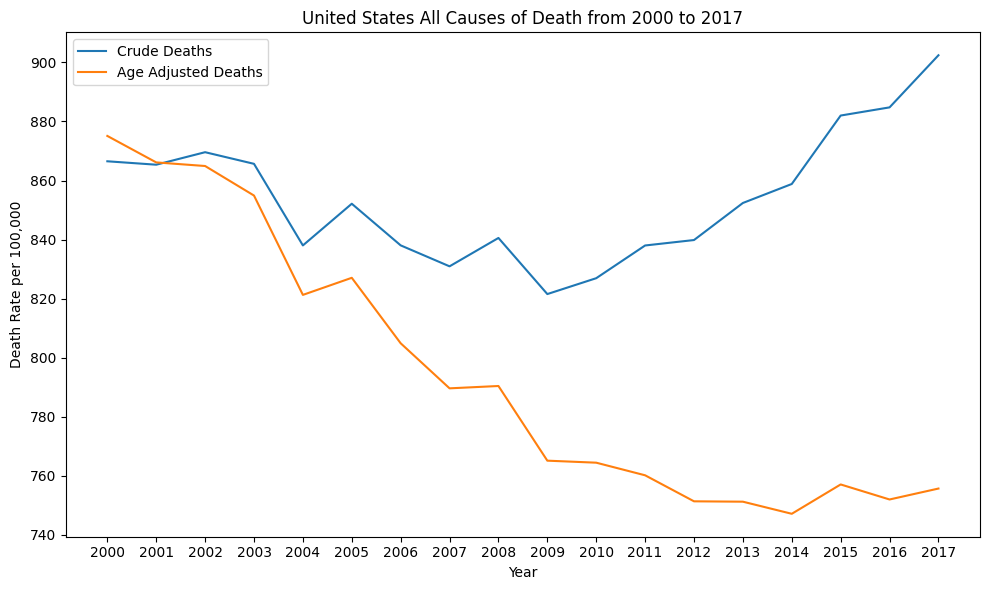

In [15]:
all = all_df[(all_df.cause_name == 'All causes') & \
             (all_df.state != 'United States')]
crude = all.groupby(['year', 'state', 'cause_name']).agg({'crude_deaths': 'max'}). \
            sort_values('crude_deaths', ascending=False).reset_index()
age = all.groupby(['year', 'state', 'cause_name']).agg({'age_adjusted': 'max'}). \
          sort_values('age_adjusted', ascending=False).reset_index()
fig, ax = plt.subplots(figsize=(10, 6))
ax.set(xlabel='Year', ylabel='Death Rate per 100,000',
       title='United States All Causes of Death from 2000 to 2017')
ax.xaxis.set_ticks(np.arange(2000, 2018, 1))
p = sns.lineplot(data=crude, x='year', y='crude_deaths', ci=None, label='Crude Deaths')
p = sns.lineplot(data=age, x='year', y='age_adjusted', ci=None, label='Age Adjusted Deaths')

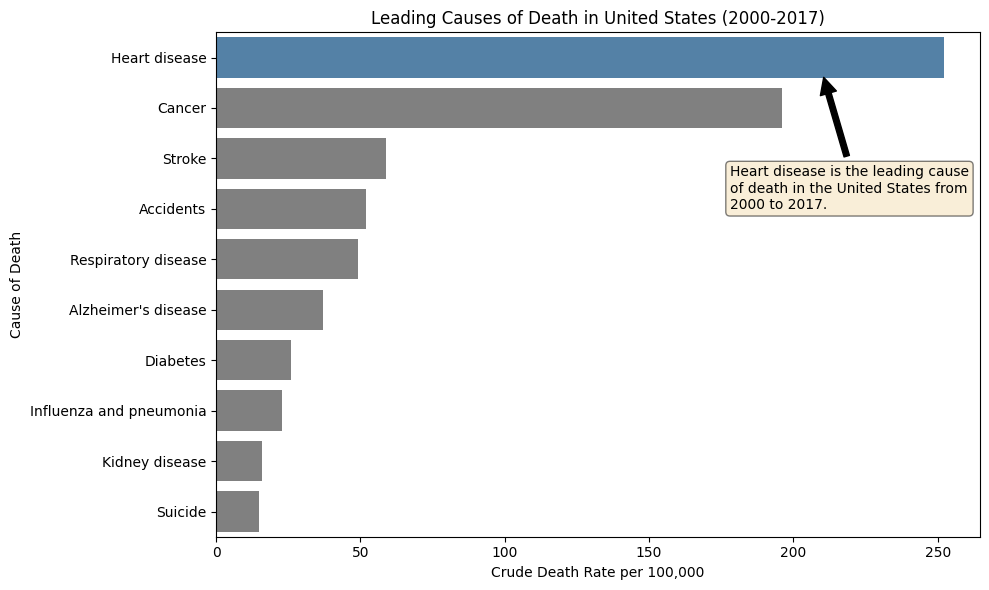

In [18]:
not_all = all_df[(all_df.cause_name != 'All causes') & \
                 (all_df.state == 'United States')] 
p_usa = not_all.groupby('cause_name').agg({'crude_deaths':'max'}). \
                sort_values('crude_deaths', ascending=False).reset_index()
fig, ax = plt.subplots(figsize=(10,6))
cols = ['grey' if (x < max(p_usa.crude_deaths)) else 'steelblue' \
               for x in p_usa.crude_deaths]
sns.barplot(data=p_usa, y='cause_name', x='crude_deaths', ci=None, palette=cols)
ax.set(xlabel='Crude Death Rate per 100,000', ylabel='Cause of Death',
       title='Leading Causes of Death in United States (2000-2017)')
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
text1 = '\n'.join(('Heart disease is the leading cause',
                   'of death in the United States from',
                   '2000 to 2017.'))
#text2 = '\n'.join(('CLRD is Cronic Lower Respiratory',
#                   'Disease. It is a group of disorders',
#                   'affecting the lungs.'))
ax.annotate(text1, xy=(210,0.3), xytext=(178,3), bbox=props,
            fontsize=10, arrowprops=dict(facecolor='black', shrink=0.05))
#ax.annotate(text2, xy=(47,4), xytext=(70,6), bbox=props,
#            fontsize=10, arrowprops=(dict(facecolor='black', shrink=0.05)))
plt.show()
#fig.savefig('../images/allLeadingCauses.png', bbox_inches='tight', dpi=300)

TypeError: unhashable type: 'numpy.ndarray'

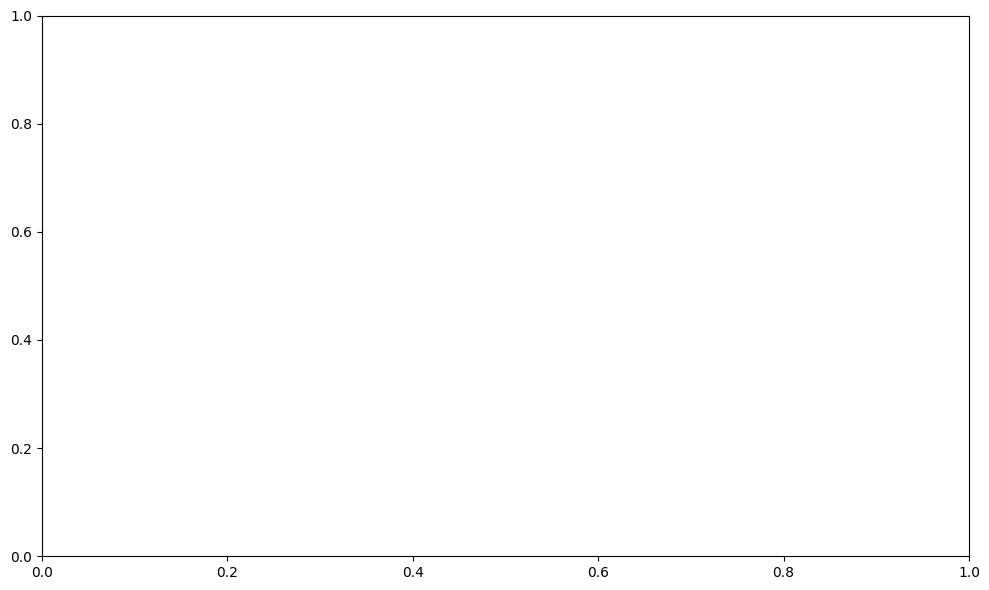

In [25]:
not_all = all_df[(all_df.cause_name != 'All causes') & \
                 (all_df.state == 'United States')] 
crude = not_all.groupby('cause_name').agg({'crude_deaths':'max'}). \
                sort_values('crude_deaths', ascending=False).reset_index()
age = not_all.groupby('cause_name').agg({'age_adjusted':'max'}). \
              sort_values('age_adjusted', ascending=False).reset_index()

fig, ax = plt.subplots(figsize=(10,6))
plt.show()

In [17]:
stop

NameError: name 'stop' is not defined

In [ ]:
heart = causes_df[(causes_df.cause_name == 'Heart disease') & \
                  (causes_df.state == 'United States')]
cancer = causes_df[(causes_df.cause_name == 'Cancer') & \
                   (causes_df.state == 'United States')]
stroke = causes_df[(causes_df.cause_name == 'Stroke') & \
                   (causes_df.state == 'United States')]
uninte = causes_df[(causes_df.cause_name == 'Unintentional injuries') & \
                   (causes_df.state == 'United States')]
clrd = causes_df[(causes_df.cause_name == 'CLRD') &
                 (causes_df.state == 'United States')]
alzhe = causes_df[(causes_df.cause_name == 'Alzheimer\'s disease') & \
                  (causes_df.state == 'United States')]
dm = causes_df[(causes_df.cause_name == 'Diabetes') & \
               (causes_df.state == 'United States')]
ian = causes_df[(causes_df.cause_name == 'Influenza and pneumonia') & \
                (causes_df.state == 'United States')]
kid = causes_df[(causes_df.cause_name == 'Kidney disease') & \
                (causes_df.state == 'United States')]
suicide = causes_df[(causes_df.cause_name == 'Suicide') & \
                    (causes_df.state == 'United States')]

layout = go.Layout(autosize=False, width=800, height=600, template='simple_white',
                  title='United States Leading Causes of Death 1999 to 2017')
fig = go.Figure(layout=layout)
#fig.update_layout(labels={'crude_deaths': 'Crude Deaths per 100,000', 'year': 'Year'})
fig.add_trace(go.Scatter(x=heart.year, y=heart.crude_deaths, mode='lines',
                         name='Heart Disease'))
fig.add_trace(go.Scatter(x=cancer.year, y=cancer.crude_deaths, mode='lines',
                         name='Cancer'))
fig.add_trace(go.Scatter(x=stroke.year, y=stroke.crude_deaths, mode='lines',
                         name='Stroke'))
fig.add_trace(go.Scatter(x=uninte.year, y=uninte.crude_deaths, mode='lines',
                         name='Unintended Injuries'))
fig.add_trace(go.Scatter(x=clrd.year, y=clrd.crude_deaths, mode='lines',
                         name='CLRD'))
fig.add_trace(go.Scatter(x=alzhe.year, y=alzhe.crude_deaths, mode='lines',
                         name='Alzheimer\'s Disease'))
fig.add_trace(go.Scatter(x=dm.year, y=dm.crude_deaths, mode='lines',
                         name='Diabetes'))
fig.add_trace(go.Scatter(x=suicide.year, y=suicide.crude_deaths, mode='lines',
                         name='Suicide'))
fig.show()

In [ ]:
plot = usa_all.groupby(['cause_name', 'year']).agg({'crude_deaths': 'max'}). \
               sort_values('crude_deaths', ascending=False).reset_index()
fig, ax = plt.subplots(figsize=(10,6))
ax.xaxis.set_ticks(np.arange(1999, 2018, 1))
sns.lineplot(data=plot, x='year', y='crude_deaths', hue='cause_name')
labelLines(plt.gca().get_lines())

In [ ]:
usa_all.groupby(['cause_name', 'year']).agg({'crude_deaths': 'max'}). \
               sort_values('crude_deaths', ascending=False).reset_index()
names = ['Unintentional injuries', 'Alzheimer\'s disease